# Link Analysis

# Table of Content

- [Setup](#setup)
- [Hits](#hits)
- [PageRank](#pagerank)
- [SimRank](#simrank)
- [Result Analysis and Discussion](#result)
- [Computation Performance Analysis](#performance)

---
# <a name='setup'></a> Setup

In [1]:
%matplotlib inline
%load_ext memory_profiler

In [2]:
from collections import namedtuple
from copy import deepcopy
from pprint import PrettyPrinter

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
pp = PrettyPrinter(indent=4)

## Load Data

In [4]:
Edge = namedtuple('Edge', ('source', 'dest'))

In [5]:
def load_graph_gen(filename):
    with open(filename, 'r') as input_file:
        for line in input_file:
            source, dest = line.strip().split(',')
            yield Edge(source, dest)

In [6]:
file_name_template = 'dataset/graph_{num}.txt'

graphs = list()
for i in range(1, 7):
    filename = file_name_template.format(num=i)
    graph_gen = load_graph_gen(filename)
    graphs.append(nx.DiGraph(graph_gen))

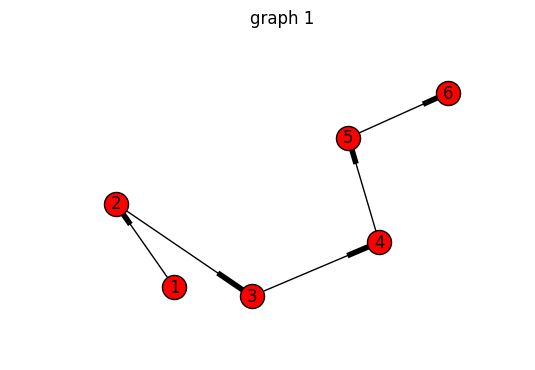

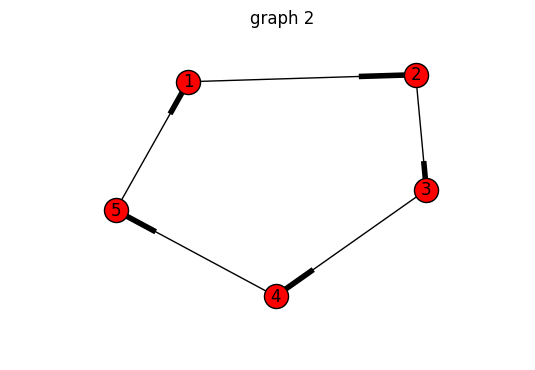

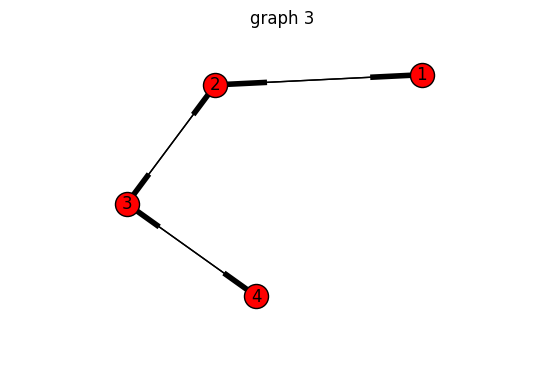

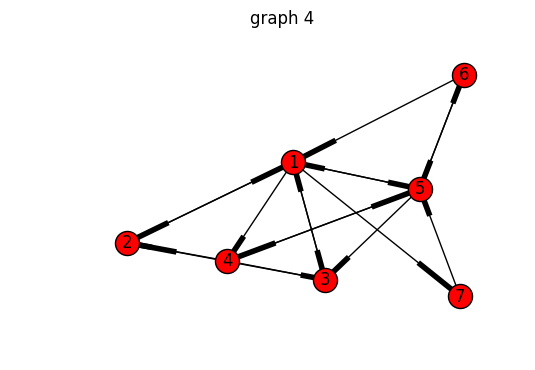

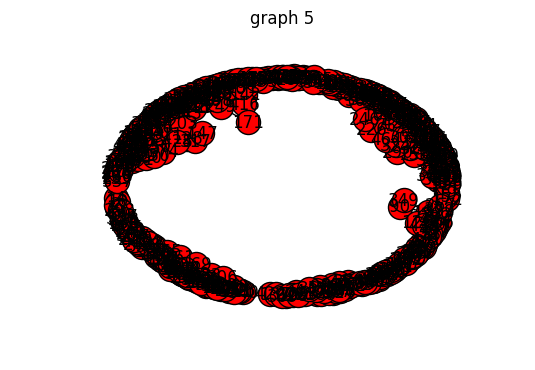

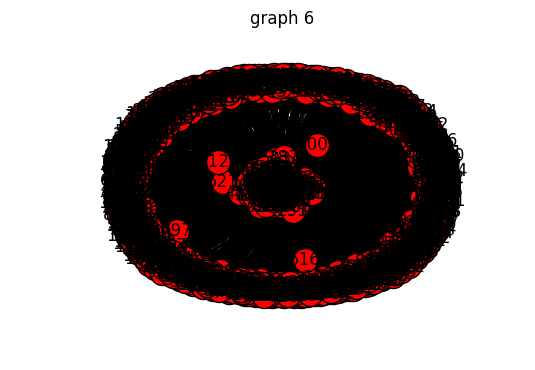

In [7]:
# Visualize  graphs
for index, graph in enumerate(graphs, 1):
    plt.figure(index)
    plt.title('graph {index}'.format(index=index))
    nx.draw(graph, arrows=True, with_labels=True)

In [8]:
G2 = nx.DiGraph()
G2.add_edges_from([(1,3),(2,3),(3,4),(4,1)])

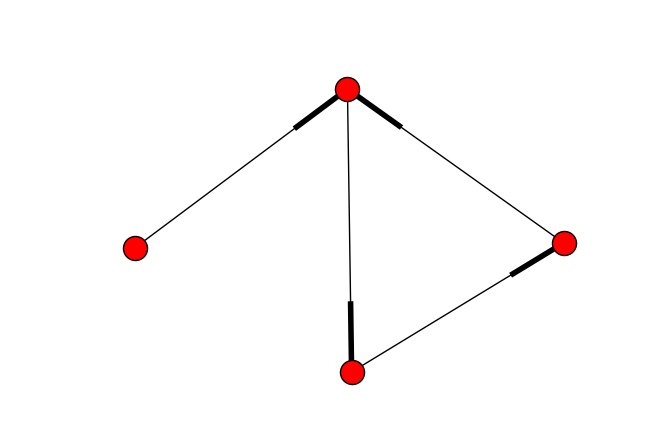

In [9]:
nx.draw(G2)
plt.show()

---
# <a name='hits'></a> Hits

## self implement of HITS

In [10]:
def initGraph(G):
    for node in G:
        G.add_node(node, authority=1)
        G.add_node(node, hub=1)
    return G

In [11]:
def normalized(G, h, a):
    totalH, totalA, t = 0, 0, 0
    for node in G:
        totalH += h[node]
        totalA += a[node]
    for node in G:
        t += h[node] / totalH - G.node[node]['hub']
        G.node[node]['hub'] = h[node] / totalH
        G.node[node]['authority'] = a[node] / totalA
    return G,t

In [12]:
def authorityHub(G, h, a):
    for node in G:
        h[node], a[node] = 0,0
        for ch in G.successors(node):
            h[node] += G.node[ch]['authority']
        for pa in G.predecessors(node):
            a[node] += G.node[pa]['hub']
    G,t = normalized(G,h,a)
    return G,h,a,t

In [13]:
def HITS(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    h, a = {}, {}
    initGraph(G)
    it, t = 0, 1
    while it < max_iter and t > tol:
        G,h,a,t = authorityHub(G,h,a)
        it += 1
    for node in G:
        h[node] = G.node[node]['hub']
        a[node] = G.node[node]['authority']        
    return h,a

In [14]:
G2.successors(1) # = G2.neighbors(1)

[3]

In [15]:
G2.predecessors(3)

[1, 2]

In [16]:
G2.nodes(data=True)

[(1, {}), (2, {}), (3, {}), (4, {})]

In [17]:
def normal(m):
    total = np.sum(m)
    return m/total

In [18]:
def compare(m1, m2):
    result = np.sum(m1) - np.sum(m2)
    return abs(result)

In [19]:
def hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True):
    k = G.number_of_nodes()
    nodeDict, Hub, Auth = {}, {}, {}
    i, it = 0, 0
    for node in G:
        nodeDict[node] = i
        i += 1
        
    A = np.zeros((k, k))
    for node in G:    
        for n in G.neighbors(node):
            A[nodeDict[node]][nodeDict[n]] = 1
    A.shape=(k,k)  
    AT = np.transpose(A)
    
    h0 = np.ones((k,1))
    a0 = np.ones((k,1))    
    
    pre_h = normal(A.dot(a0))
    pre_a = normal(AT.dot(h0))
    
    h = normal(A.dot(pre_a))
    a = normal(AT.dot(pre_h))

    while it <= max_iter and (compare(h, pre_h) + compare(a, pre_a)) > tol:
        pre_h, pre_a = h, a
        h = normal(A.dot(pre_a))
        a = normal(AT.dot(pre_h))
        it += 1
    
    for key in nodeDict.keys():
        Hub[key] = h[nodeDict[key]][0]
        Auth[key] = a[nodeDict[key]][0]
        
    return Hub, Auth

In [20]:
h2, a2 = hits(G2)
print(h2)
print(a2)

{1: 0.33333333333333331, 2: 0.33333333333333331, 3: 0.16666666666666666, 4: 0.16666666666666666}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [21]:
h3, a3 = HITS(G2)
print(h3)
print(a3)

{1: 0.25, 2: 0.25, 3: 0.25, 4: 0.25}
{1: 0.25, 2: 0.0, 3: 0.5, 4: 0.25}


In [22]:
h, a = nx.hits(G2)
print(h)
print(a)

{1: 0.49999999813735485, 2: 0.49999999813735485, 3: 1.8626451422920631e-09, 4: 1.8626451422920631e-09}
{1: 3.7252902707063384e-09, 2: 0.0, 3: 0.9999999925494194, 4: 3.7252902707063384e-09}


In [23]:
nx.hits(graphs[0])

({'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2, '6': 0.0},
 {'1': 0.0, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2, '6': 0.2})

In [24]:
hits(graphs[0])

({'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001,
  '6': 0.0},
 {'1': 0.0,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001,
  '6': 0.20000000000000001})

In [25]:
nx.hits(graphs[1])

({'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2},
 {'1': 0.2, '2': 0.2, '3': 0.2, '4': 0.2, '5': 0.2})

In [26]:
hits(graphs[1])

({'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001},
 {'1': 0.20000000000000001,
  '2': 0.20000000000000001,
  '3': 0.20000000000000001,
  '4': 0.20000000000000001,
  '5': 0.20000000000000001})

In [27]:
nx.hits(graphs[2])

({'1': 0.1909830056647784,
  '2': 0.3090169943352216,
  '3': 0.3090169943352216,
  '4': 0.1909830056647784},
 {'1': 0.190983005521049,
  '2': 0.309016994478951,
  '3': 0.309016994478951,
  '4': 0.190983005521049})

In [28]:
hits(graphs[2])

({'1': 0.20000000000000001,
  '2': 0.30000000000000004,
  '3': 0.30000000000000004,
  '4': 0.20000000000000001},
 {'1': 0.20000000000000001,
  '2': 0.30000000000000004,
  '3': 0.30000000000000004,
  '4': 0.20000000000000001})

In [29]:
nx.hits(graphs[3])

({'1': 0.27545317656543444,
  '2': 0.04776230637693576,
  '3': 0.10868323971440082,
  '4': 0.1986595564890898,
  '5': 0.18373459934253686,
  '6': 0.11673471394426904,
  '7': 0.06897240756733328},
 {'1': 0.13948389308544967,
  '2': 0.1779120314091907,
  '3': 0.20082320536937326,
  '4': 0.1401777533243232,
  '5': 0.20142536348733986,
  '6': 0.056089261885683465,
  '7': 0.08408849143863971})

In [30]:
hits(graphs[3])

({'1': 0.23214285714285712,
  '2': 0.071428571428571425,
  '3': 0.12499999999999999,
  '4': 0.17857142857142855,
  '5': 0.17857142857142858,
  '6': 0.14285714285714285,
  '7': 0.071428571428571425},
 {'1': 0.15000000000000002,
  '2': 0.16666666666666669,
  '3': 0.20000000000000001,
  '4': 0.15000000000000002,
  '5': 0.18333333333333338,
  '6': 0.066666666666666666,
  '7': 0.083333333333333343})

In [31]:
nx.hits(graphs[4])

({'1': 1.0324628273669702e-19,
  '10': 0.0,
  '100': 0.0,
  '101': 0.0,
  '102': 0.0,
  '103': 0.015029664084517768,
  '104': 0.0,
  '105': 0.0,
  '106': 1.0117920165556642e-20,
  '107': 0.0,
  '108': 0.0,
  '109': 2.740296779057304e-13,
  '11': 9.257103567698096e-20,
  '110': 0.0,
  '111': 0.0,
  '112': 0.0,
  '113': 8.038356894932674e-21,
  '114': 0.0,
  '115': 0.025439142792896677,
  '116': 0.0,
  '117': 0.0,
  '118': 0.0,
  '119': 5.489633966153881e-19,
  '12': 1.4474920182582852e-11,
  '120': 0.0,
  '121': 0.0,
  '122': 0.0,
  '123': 0.0,
  '124': 4.991317017051913e-40,
  '125': 0.0,
  '126': 0.0,
  '127': 0.0,
  '128': 0.0,
  '129': 0.0,
  '13': 4.991317017051913e-40,
  '130': 0.013842952127041392,
  '131': 1.3720027745412005e-28,
  '132': 0.0,
  '133': 0.0,
  '134': 0.021287426703584116,
  '135': 0.0,
  '136': 0.0,
  '137': 0.0,
  '138': 0.0,
  '139': 0.0,
  '14': 0.0,
  '140': 0.0,
  '141': 0.014359677890185368,
  '142': 0.0,
  '143': 4.991317017051913e-40,
  '144': 0.0,
  '145

In [32]:
hits(graphs[4])

({'1': 0.0015337423312883434,
  '10': 0.0,
  '100': 0.0,
  '101': 0.0,
  '102': 0.0,
  '103': 0.013081919884518227,
  '104': 0.0,
  '105': 0.0,
  '106': 0.0019848430169613859,
  '107': 0.0,
  '108': 0.0,
  '109': 0.0027066041140382537,
  '11': 0.0010826416456153013,
  '110': 0.0,
  '111': 0.0,
  '112': 0.0,
  '113': 0.00027066041140382533,
  '114': 0.0,
  '115': 0.019667989895344642,
  '116': 0.0,
  '117': 0.0,
  '118': 0.0,
  '119': 0.0026163839769036447,
  '12': 0.0061349693251533735,
  '120': 0.0,
  '121': 0.0,
  '122': 0.0,
  '123': 0.0,
  '124': 0.00018044027426921688,
  '125': 0.0,
  '126': 0.0,
  '127': 0.0,
  '128': 0.0,
  '129': 0.0,
  '13': 0.00018044027426921688,
  '130': 0.01154817755322988,
  '131': 0.0007217610970768675,
  '132': 0.0,
  '133': 0.0,
  '134': 0.017232046192710213,
  '135': 0.0,
  '136': 0.0,
  '137': 0.0,
  '138': 0.0,
  '139': 0.0,
  '14': 0.0,
  '140': 0.0,
  '141': 0.012269938650306749,
  '142': 0.0,
  '143': 0.00018044027426921688,
  '144': 0.0,
  '145'

In [33]:
#nx.hits(graphs[5])

In [34]:
hits(graphs[5])

({'494': 0.0,
  '321': 0.0,
  '208': 0.0,
  '1000': 0.0,
  '351': 0.0,
  '1144': 0.0,
  '112': 0.0,
  '696': 0.0,
  '535': 0.0,
  '559': 0.0078114924740691621,
  '429': 0.0,
  '64': 0.0,
  '1110': 0.0,
  '763': 0.0,
  '612': 0.0,
  '71': 0.0,
  '501': 0.0087971406989811891,
  '290': 0.0078299158053759272,
  '879': 0.0,
  '467': 0.0,
  '1069': 0.0,
  '229': 0.0,
  '367': 0.0,
  '10': 0.0,
  '1015': 0.0027174413677481164,
  '477': 0.0067889975865435982,
  '978': 0.0,
  '798': 0.0,
  '703': 0.0,
  '1201': 0.0,
  '1104': 0.0,
  '705': 0.0,
  '1128': 0.0,
  '486': 0.0,
  '1152': 0.0,
  '771': 9.2116656533834456e-05,
  '316': 0.0,
  '601': 0.0,
  '660': 0.0,
  '168': 0.0,
  '929': 0.0079496674588699114,
  '1217': 0.0,
  '442': 0.0,
  '62': 0.0061257576594999901,
  '609': 0.0,
  '650': 0.0014001731793142839,
  '344': 0.0,
  '940': 0.0,
  '920': 0.0073509091913999888,
  '1097': 0.0,
  '193': 0.0,
  '828': 0.0,
  '1145': 0.0,
  '482': 0.0,
  '1184': 0.0,
  '352': 0.0014646548388879679,
  '20': 

In [35]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    #pp.pprint(nx.hits(graph))


Graph 1

Graph 2

Graph 3

Graph 4

Graph 5

Graph 6


---
# <a name='pagerank'></a> Page Rank

In [36]:
def pagerank(graph, *, alpha=0.85, episilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    out_degs = np.sum(adj_matrix, axis=1)
    damping_factor = 1 - alpha
    
    # Nodes with no outgoing edges
    dangle_nodes = [
        index
        for index, o_deg in enumerate(graph.out_degree().values())
        if not o_deg
    ]
    
    # Page Ranks
    prs = np.array([1/node_num for _ in range(node_num)])
    # Page Ranks in previous iteration
    pre_prs = np.array([0 for _ in range(node_num)])
    
    delta = np.sum(np.abs(prs - pre_prs))
    while delta > episilon:
        pre_prs = deepcopy(prs)
        
        # Page Rank values each node can contribute in each edge
        pr_quotas = np.array(
            [pr/deg if deg else 0 for pr, deg in zip(pre_prs, out_degs)]
        )
        dangle_sum = np.sum([pre_prs[dangle_node]/node_num
                             for dangle_node in dangle_nodes])

        prs = (
            damping_factor / node_num +
            alpha *
            (
                adj_matrix.transpose().dot(pr_quotas[:, np.newaxis]) +
                dangle_sum
            )
        ).flatten()
        
        # Normalize
        prs /= np.sum(prs)
        delta = np.sum(np.abs(prs - pre_prs))
        
    # Mapping node name to its page rank
    prs_mappping = {node: pr for node, pr in zip(graph.nodes(), prs)}
    return prs_mappping

### Reference 
[PageRank Lecture Note](http://www.ccs.northeastern.edu/home/daikeshi/notes/PageRank.pdf)

---
# <a name='simrank'></a> SimRank

In [37]:
np.seterr(divide='ignore', invalid='ignore')

def simrank(graph, *, C=0.8, epsilon=1e-06):
    node_num = graph.number_of_nodes()
    adj_matrix = np.array(nx.to_numpy_matrix(graph))
    adj_matrix /= np.sum(adj_matrix, axis=0)
    adj_matrix = np.nan_to_num(adj_matrix)
    
    pre_sim = np.zeros(node_num)
    sim = np.eye(node_num)
    delta = np.sum(np.abs(sim - pre_sim))
    while delta > epsilon:
        pre_sim = deepcopy(sim)
        sim = C * adj_matrix.transpose().dot(pre_sim).dot(adj_matrix)
        for i in range(node_num):
            sim[i, i] = 1
        delta = np.sum(np.abs(sim - pre_sim))
    return sim

---

# <a name='result'></a> Result Analysis and Discussion

## Hits

## Page Rank

In [38]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(pagerank(graph))


Graph 1
{   '1': 0.058655565376264075,
    '2': 0.10979760045012729,
    '3': 0.15438862918295584,
    '4': 0.19326787502679452,
    '5': 0.22716690845064277,
    '6': 0.25672342151321548}

Graph 2
{   '1': 0.20000000000000001,
    '2': 0.20000000000000001,
    '3': 0.20000000000000001,
    '4': 0.20000000000000001,
    '5': 0.20000000000000001}

Graph 3
{   '1': 0.17543856058862933,
    '2': 0.32456143941137072,
    '3': 0.32456143941137072,
    '4': 0.17543856058862933}

Graph 4
{   '1': 0.2802878551778531,
    '2': 0.15876446265602653,
    '3': 0.13888181220259521,
    '4': 0.10821960072742,
    '5': 0.18419809708011367,
    '6': 0.060570694570464531,
    '7': 0.069077477585526889}

Graph 5
{   '1': 0.0016199030827286323,
    '10': 0.0019550825437949005,
    '100': 0.0017215290739660107,
    '101': 0.0016767299691853529,
    '102': 0.0016784110093977255,
    '103': 0.0017119305912636871,
    '104': 0.0099755145727123285,
    '105': 0.0026182677057220698,
    '106': 0.00196461017913

## Sim Rank

In [39]:
for index, graph in enumerate(graphs, 1):
    print('\nGraph {}'.format(index))
    pp.pprint(simrank(graph))


Graph 1
array([[ 1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.]])

Graph 2
array([[ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.]])

Graph 3
array([[ 1.        ,  0.        ,  0.66666655,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.66666655],
       [ 0.66666655,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.66666655,  0.        ,  1.        ]])

Graph 4
array([[ 1.        ,  0.27314849,  0.53506349,  0.27012699,  0.44809422,
         0.41507678,  0.2854419 ],
       [ 0.27314849,  1.        ,  0.3426946 ,  0.4122407 ,  0.39005383,
         0.33765876,  0.41218164],
       [ 0.53506349,  0.3426946 ,  1.        ,  0.53506349,  0.44956621,
         0.35373453,  0.

# <a name='performance'></a> Computation Performance Analysis

## Time

### Hits

### Page Rank

In [40]:
%%time

for graph in graphs:
    pagerank(graph)

CPU times: user 56.3 ms, sys: 9.61 ms, total: 65.9 ms
Wall time: 57.2 ms


In [41]:
%%time

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

CPU times: user 68.7 ms, sys: 2.56 ms, total: 71.3 ms
Wall time: 70.7 ms


### SimRank

In [42]:
%%time

for graph in graphs:
    simrank(graph)

CPU times: user 46.5 s, sys: 1.26 s, total: 47.7 s
Wall time: 15.8 s


## Memory

### Hits

### Page Rank

In [43]:
%%memit

for graph in graphs:
    pagerank(graph)

peak memory: 143.60 MiB, increment: 23.97 MiB


In [44]:
%%memit

for graph in graphs:
    nx.pagerank(graph, alpha=0.85)

peak memory: 143.98 MiB, increment: 0.88 MiB


###  SimRank

In [45]:
%%memit

for graph in graphs:
    simrank(graph)

peak memory: 182.99 MiB, increment: 39.01 MiB
